In [1]:
from src.functions import *

In [2]:
n = 4

In [3]:
num_random_models = 50

gamma_lims = (0,1) 
gamma_steps = 25
gamma_range = np.linspace(gamma_lims[0], gamma_lims[1], gamma_steps)

T = 0

In [4]:
def qea(H, T):
    '''Edward-Anderson parameter'''
    d = len(H)
    n = int(np.log2(d))
    E, vecs = la.eigh(H)
    if T == 0:
        boltzmann_factors = np.array(E == min(E), dtype=int) / sum(np.array(E == min(E), dtype=int))
    else:
        boltzmann_factors = scipy.special.softmax(-E / T)

    Z_matrices = [Z(i, n) for i in range(n)]
    qea = 0
    for i in range(n):
        sigma_i = Z_matrices[i]
        s = np.sum([vec @ sigma_i @ vec.T * boltzmann_factors[vec_index]
                    for vec_index, vec in enumerate(vecs.T)])
        qea += s**2

    return qea / n

def qea_2(H, T):
    d = len(H)
    n = int(np.log2(d))
    E, vecs = la.eigh(H)
    if T == 0:
        boltzmann_factors = np.array(E == min(E), dtype=int) / sum(np.array(E == min(E), dtype=int))
    else:
        boltzmann_factors = scipy.special.softmax(-E / T)

    Z_matrices = [Z(i, n) for i in range(n)]
    qea = 0
    for i in range(n):
        for j in range(n):
            sigma_i = Z_matrices[i]
            sigma_j = Z_matrices[j]
            s = np.sum([vec @ sigma_i @ sigma_j @ vec.T * boltzmann_factors[vec_index]
                        for vec_index, vec in enumerate(vecs.T)])
            qea += s**2

    return qea / n**2

def qea_4(H, T):
    d = len(H)
    n = int(np.log2(d))
    E, vecs = la.eigh(H)
    
    if T == 0:
        min_E_mask = E == min(E)
        boltzmann_factors = min_E_mask / np.sum(min_E_mask)
    else:
        boltzmann_factors = scipy.special.softmax(-E / T)

    Z_matrices = [Z(i, n) for i in range(n)]    
    qea = 0
    for i in range(n):
        sigma_i = Z_matrices[i]
        for j in range(n):
            sigma_j = Z_matrices[j]
            for k in range(n):
                sigma_k = Z_matrices[k]
                for l in range(n):
                    sigma_l = Z_matrices[l]
                    
                    s = np.sum([vec.T @ sigma_i @ sigma_j @ sigma_k @ sigma_l @ vec * boltzmann_factors[vec_index]
                                for vec_index, vec in enumerate(vecs.T)])
                    qea += s**2

    return qea / n**4

def binder_cumulant(H, T):
    m4 = qea_4(H, T)
    m2 = qea_2(H, T)
    g = 0.5*(3 - m4/(m2**2))
    return g

In [5]:
def f_binder(gamma):
    g = np.zeros(num_random_models)
    for i in range(num_random_models):
        m = RandomIsingModel(n, seed=i)
        H_ising = np.diag(m.E_rescaled)
        H_mixer = H_mixer_list[m.n-1]
        H = (1-gamma)*H_ising + gamma*H_mixer
        g[i] = binder_cumulant(H, T)
    return g

In [6]:
sweep_data = np.asarray(joblib.Parallel(n_jobs=-1)(joblib.delayed(f_binder)(gamma) for gamma in tqdm(gamma_range)))

  0%|          | 0/25 [00:00<?, ?it/s]

 96%|█████████▌| 24/25 [00:00<00:00, 93.97it/s]

100%|██████████| 25/25 [00:00<00:00, 92.89it/s]

In [7]:
g = sweep_data.copy()
g_avg = np.mean(g, axis=1)
g_std = np.std(g, axis=1)

# Save the data

In [8]:
grid_search = {'g': g.tolist(),
               'g_avg': g_avg.tolist(),
               'g_std': g_std.tolist(),
               'num_random_models': num_random_models,
               'gamma_range': gamma_range.tolist(),
               'T': T,
               'n': n}

save_in_json(grid_search, f'data/binder_cumulant_n{n}_T0.json')

# Plot the results

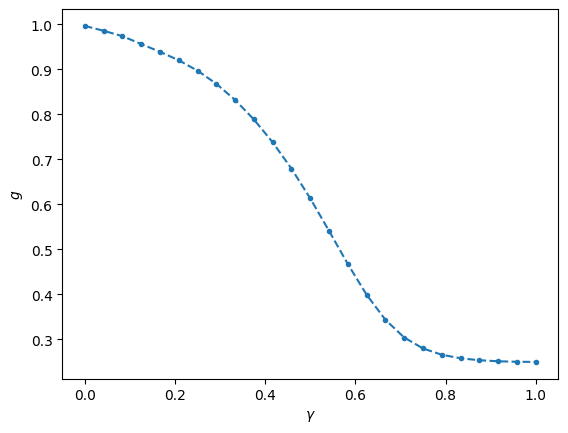

In [9]:
plt.plot(gamma_range, g_avg, '.--')
plt.ylabel('$g$')
plt.xlabel('$\gamma$')
plt.show()